### Выполнили: Грудинин Михаил и Дмитрий Климовский 23Б16

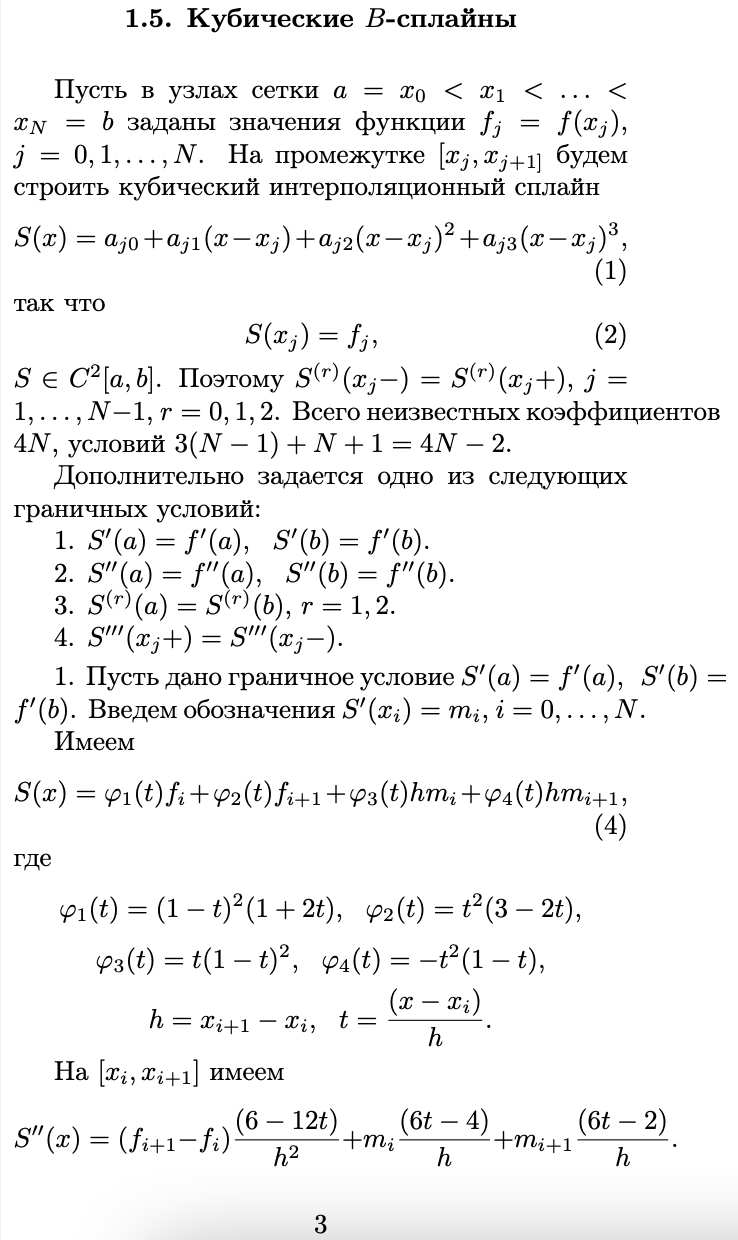

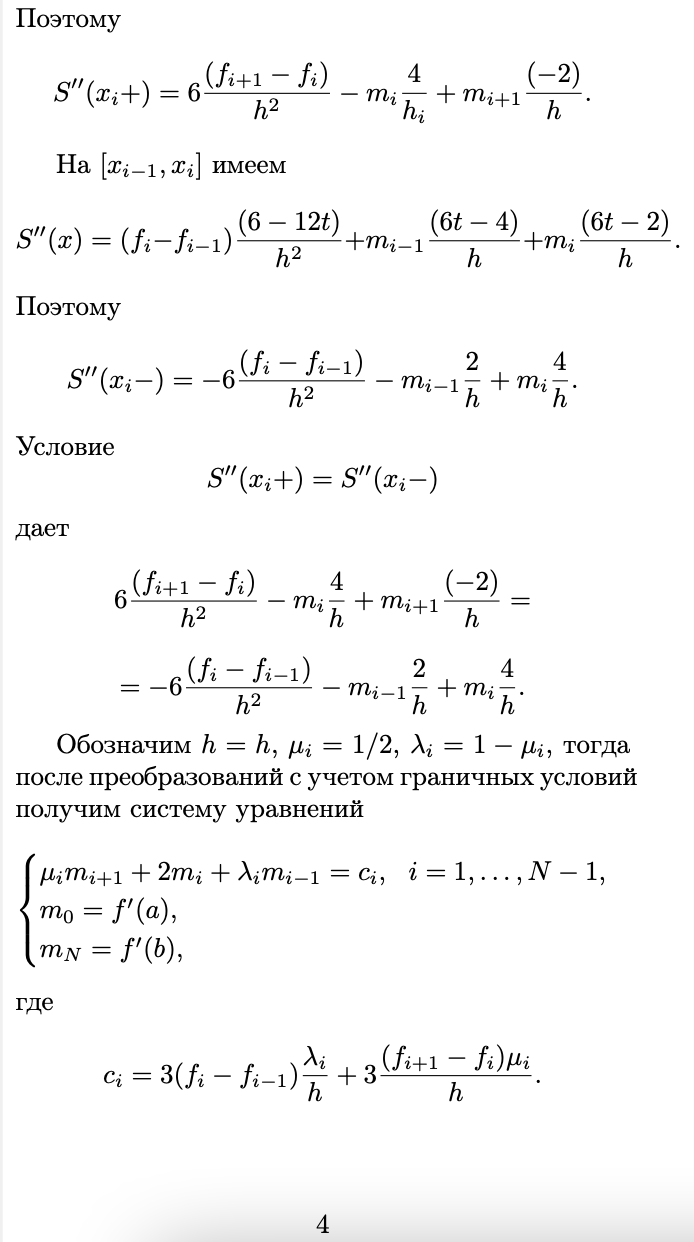

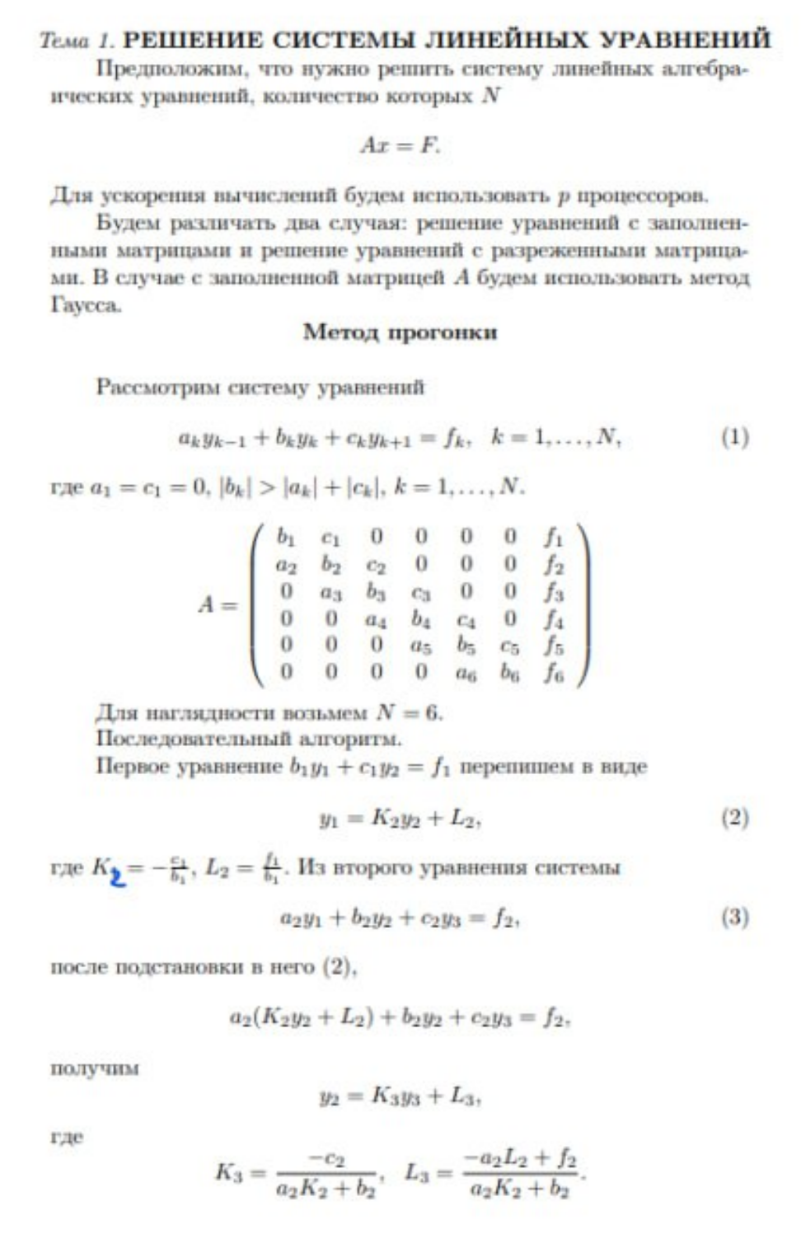

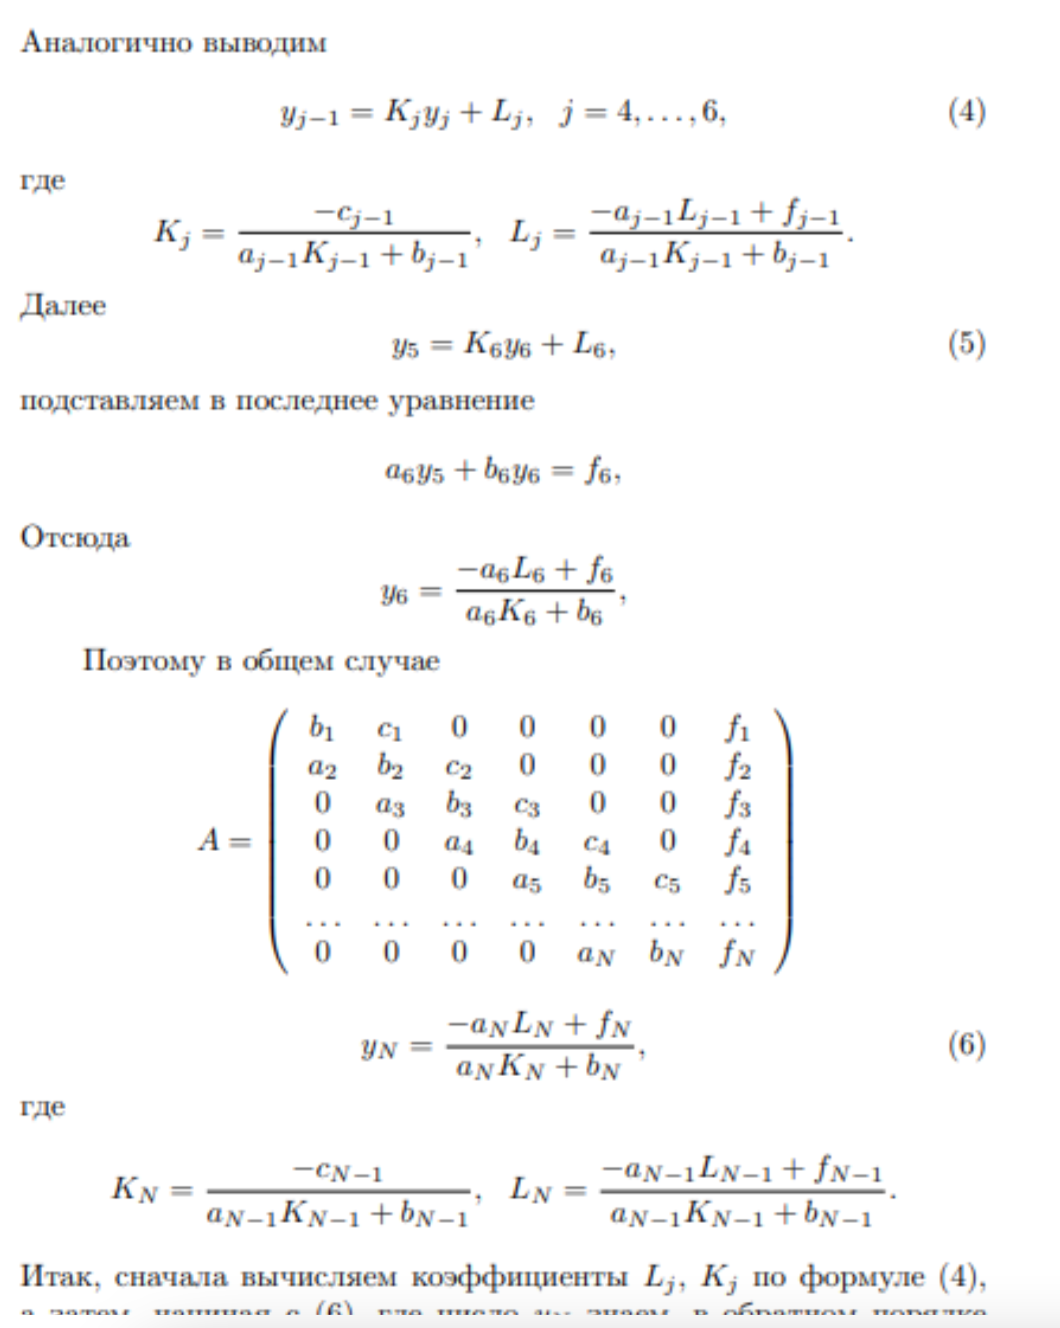

### Задача: Построить кубический B-сплайн по значениям функции $ f(x) = \frac{1}{1 + 25x^2} $ в узлах равномерной сетки узлов {$ {x_i} $} с шагом h: $ {x_i} $ = $ {h_i} $, i = 1,...,n, n = 5. Найти решения системы уравнений методом прогонки.

Импортируем необходимые библиотеки

In [123]:
import numpy as np
import matplotlib.pyplot as plt

Задаем функцию и её производную

In [124]:
def f(x):
    return 1 / (1 + 25 * x**2)

def f_prime(x):
    return -50 * x / (1 + 25 * x**2)**2

Задаем количество узлов

In [125]:
n = 5

Задаем узлы и шаг

In [126]:
x_nodes = np.linspace(-1, 1, n)
y_nodes = f(x_nodes)

h = x_nodes[1] - x_nodes[0]

In [127]:
print(x_nodes)
print(y_nodes)
print(h)

[-1.  -0.5  0.   0.5  1. ]
[0.03846154 0.13793103 1.         0.13793103 0.03846154]
0.5


Формирование системы уравнений для прогонки

In [128]:
mu = 1/2
lambd = 1 - mu

A = np.zeros((n, n))
b = np.zeros(n)

Заполняем матрицу и вектор правой части

In [129]:
for i in range(1, n-1):
    A[i, i-1] = lambd  # λ_i * m_{i-1}
    A[i, i] = 2        # 2 * m_i
    A[i, i+1] = mu     # μ_i * m_{i+1}
    b[i] = 3 * ((y_nodes[i+1] - y_nodes[i]) * mu + (y_nodes[i] - y_nodes[i-1]) * lambd) / h 


In [130]:
A

array([[0. , 0. , 0. , 0. , 0. ],
       [0.5, 2. , 0.5, 0. , 0. ],
       [0. , 0.5, 2. , 0.5, 0. ],
       [0. , 0. , 0.5, 2. , 0.5],
       [0. , 0. , 0. , 0. , 0. ]])

In [131]:
b

array([ 0.        ,  2.88461538,  0.        , -2.88461538,  0.        ])

Граничные условия

In [132]:
A[0, 0] = 1
A[-1, -1] = 1
b[0] = f_prime(x_nodes[0])    # m_0 = f'(a)
b[-1] = f_prime(x_nodes[-1])  # m_N = f'(b)

In [133]:
A

array([[1. , 0. , 0. , 0. , 0. ],
       [0.5, 2. , 0.5, 0. , 0. ],
       [0. , 0.5, 2. , 0.5, 0. ],
       [0. , 0. , 0.5, 2. , 0.5],
       [0. , 0. , 0. , 0. , 1. ]])

In [134]:
b

array([ 0.0739645 ,  2.88461538,  0.        , -2.88461538, -0.0739645 ])

Решение системы методом прогонки

In [135]:
def solve_tridiagonal(A, b):    
    n = len(b)
    K = np.zeros(n)    
    L = np.zeros(n)

    # Прямой ход
    K[1] = -A[0, 1] / A[0, 0]    
    L[1] = b[0] / A[0, 0]
    
    for i in range(1, n-1):
        denom = A[i, i] + A[i, i-1] * K[i]        
        K[i+1] = -A[i, i+1] / denom
        L[i+1] = (b[i] - A[i, i-1] * L[i]) / denom    
    
    # Обратный ход    
    x = np.zeros(n)
    x[-1] = (b[-1] - A[-1, -2] * L[-2]) / (A[-1, -1] + A[-1, -2] * K[-2])    
    
    for i in range(n-2, -1, -1):        
        x[i] = K[i+1] * x[i+1] + L[i+1]
    
    return x

In [136]:
m = solve_tridiagonal(A, b)

In [137]:
m

array([ 7.39644970e-02,  1.42381657e+00, -5.55111512e-17, -1.42381657e+00,
       -7.39644970e-02])

Функция для вычисления кубического B-сплайна

In [138]:
def cubic_b_spline(x, x_nodes, y_nodes, m, h):
    spline_values = np.zeros_like(x)
    
    for i in range(len(x_nodes) - 1):
        mask = (x >= x_nodes[i]) & (x <= x_nodes[i+1])
        xi = x_nodes[i]
        xi1 = x_nodes[i+1]
        hi = xi1 - xi
        
        fi = y_nodes[i]
        fi1 = y_nodes[i+1]
        mi = m[i]
        mi1 = m[i+1]
        
        t = (x[mask] - xi) / hi
        
        # Функции формы φ1(t), φ2(t), φ3(t), φ4(t)
        phi1 = (1 - t)**2 * (1 + 2 * t)
        phi2 = t**2 * (3 - 2 * t)
        phi3 = t * (1 - t)**2
        phi4 = -t**2 * (1 - t)
        
        # Сплайн S(x) = φ1 * fi + φ2 * fi1 + φ3 * h * mi + φ4 * h * mi1
        spline_values[mask] = (
            phi1 * fi + 
            phi2 * fi1 + 
            phi3 * hi * mi + 
            phi4 * hi * mi1
        )
    
    return spline_values

Генерируем значения для отображения сплайна и исходной функции

In [139]:
x_values = np.linspace(-1, 1, 100)
spline_values = cubic_b_spline(x_values, x_nodes, y_nodes, m, h)
true_values = f(x_values)

График сплайна и исходной функции

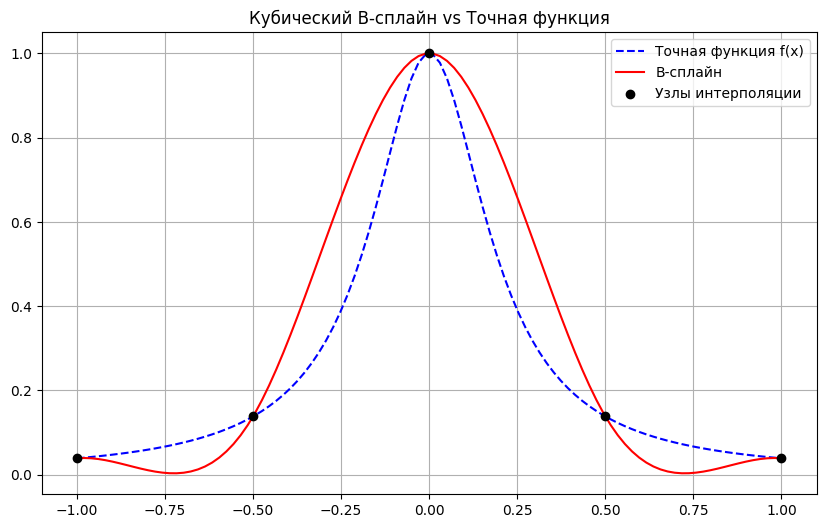

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(x_values, true_values, label="Точная функция f(x)", color="blue", linestyle="--")
plt.plot(x_values, spline_values, label="B-сплайн", color="red")
plt.scatter(x_nodes, y_nodes, label="Узлы интерполяции", color="black", zorder=5)
plt.title("Кубический B-сплайн vs Точная функция")
plt.legend()
plt.grid(True)
plt.show()

График разницы между сплайном и точной функцией

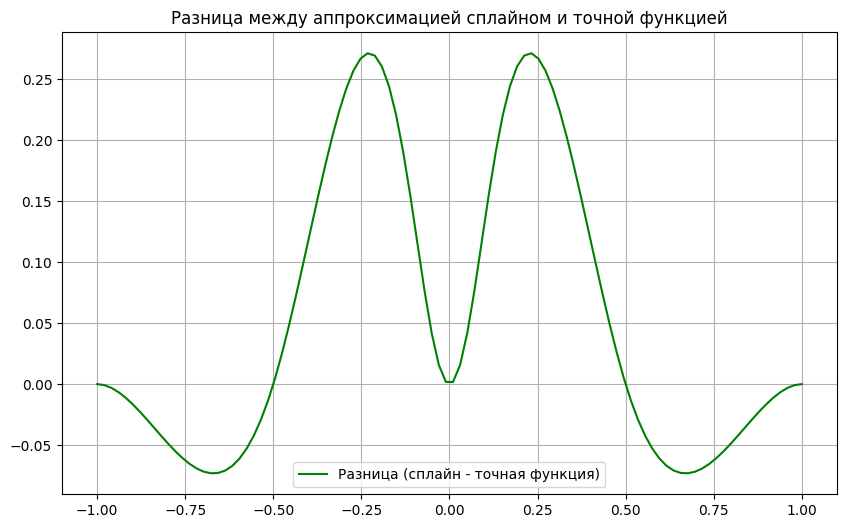

In [141]:
difference = spline_values - true_values
plt.figure(figsize=(10, 6))
plt.plot(x_values, difference, label="Разница (сплайн - точная функция)", color="green")
plt.title("Разница между аппроксимацией сплайном и точной функцией")
plt.legend()
plt.grid(True)
plt.show()